In [1]:
import os
import astra
import odl
import numpy as np
import dival
from dival import get_standard_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torch.utils.data
import custom_odl_op8 as op
import time 
from torch.optim.lr_scheduler import StepLR

In [2]:
def to_np(tensor):
    return tensor.cpu().detach().numpy()

def show_img(tensor, title=None):
    plt.figure()
    plt.imshow(to_np(tensor)) # add  , cmap='Greys_r' for grey image
    plt.title(title)
    plt.show()

'\nParameters given by the dataset\ninput: 1000*513\noutput: 362*362\n\ntrain_len = 35820\nvalidation_len = 3522\ntest_len = 3553\n\n'

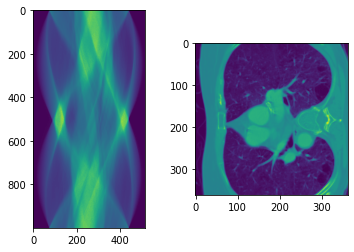

In [3]:
import dival.datasets.lodopab_dataset as lodopab
import matplotlib.pyplot as plt

#dataset = get_standard_dataset('lodopab', impl = 'skimage')
dataset = lodopab.LoDoPaBDataset(impl= 'astra_cpu')
sample_observ, sample_ground_truth = dataset.get_sample(0)
plt.subplot(1, 2, 1)
plt.imshow(sample_observ)
plt.subplot(1, 2, 2)
plt.imshow(sample_ground_truth)

'''
Parameters given by the dataset
input: 1000*513
output: 362*362

train_len = 35820
validation_len = 3522
test_len = 3553

'''

In [4]:
BATCH_SIZE = 5
training_dataset = dataset.create_torch_dataset('train')

training_data_loader = torch.utils.data.DataLoader(training_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [5]:
# In case we want to train on a subset of training data

trainset_1 = torch.utils.data.Subset(training_dataset, list(range(20))) 
trainloader_1 = torch.utils.data.DataLoader(trainset_1, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

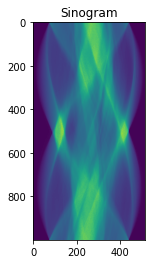

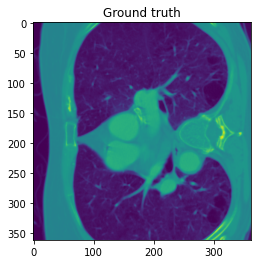

In [6]:
validation_dataset = dataset.create_torch_dataset('validation')
validation_data_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                     batch_size=BATCH_SIZE, 
                                                     shuffle=False)
#show_img(validation_dataset[0][0], 'Sinogram')
#show_img(validation_dataset[0][1], 'Ground truth')

show_img(training_dataset[0][0], 'Sinogram')
show_img(training_dataset[0][1], 'Ground truth')

In [7]:
data = dataset.get_samples(slice(0, 5, 1))
data[0].shape
data[0].shape

(5, 1000, 513)

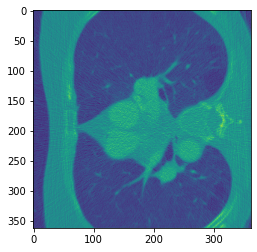

In [9]:
fbp = odl.tomo.fbp_op(dataset.ray_trafo, filter_type='Ram-Lak', frequency_scaling=1.0)
"""fbp_reconstruction = fbp(to_np(training_dataset[0][0]))
plt.imshow(fbp_reconstruction)
plt.show()"""
FBP = op.OperatorAsModule(fbp)
plt.imshow(FBP(training_dataset[0][0].unsqueeze(0).unsqueeze(1)).squeeze())

In [64]:
# for batch_id, sample in enumerate(training_data_loader):
    
#     sinogram, ground_truth = sample
    
#     print(sinogram.shape)
    
#     break

In [65]:
fbp_batch = op.OperatorAsModule(fbp)
# out = fbp_batch(torch.unsqueeze(sinogram, 1))
# print(out.shape)
# show_img(out[0][0])

In [66]:
# def FBP_batch(x):
#     y = torch.zeros((BATCH_SIZE, 362,362))
#     for i in range(BATCH_SIZE):
#         y[i] = torch.from_numpy(np.asarray(fbp(to_np(x[i]))))
#     return y

In [67]:
class UNet_5Layer(nn.Module): #exactly the same as in the paper
    def __init__(self, m = 16, n = 32, o = 64, p = 64, q = 128):
        super(UNet_5Layer, self).__init__()
        #U-net from https://arxiv.org/pdf/1910.01113v2.pdf

        self.conv1 = nn.Conv2d(1, m, 3)
        self.norm1 = torch.nn.BatchNorm2d(m)
        
        self.conv2 = nn.Conv2d(m, n, 5, stride = 2)
        self.norm2 = torch.nn.BatchNorm2d(n)
        self.conv3 = nn.Conv2d(n, n, 3)
        self.norm3 = torch.nn.BatchNorm2d(n)
        
        self.conv4 = nn.Conv2d(n, o, 3, stride = 2)
        self.norm4 = torch.nn.BatchNorm2d(o)
        self.conv5 = nn.Conv2d(o, o, 3)
        self.norm5 = torch.nn.BatchNorm2d(o)
        
        self.conv6 = nn.Conv2d(o, p, 3, stride = 2)
        self.norm6 = torch.nn.BatchNorm2d(p)
        self.conv7 = nn.Conv2d(p, p, 3)
        self.norm7 = torch.nn.BatchNorm2d(p)

        self.conv8 = nn.Conv2d(p, q, 3, stride = 2)
        self.norm8 = torch.nn.BatchNorm2d(q)
        self.conv9 = nn.Conv2d(q, q, 3)
        self.norm9 = torch.nn.BatchNorm2d(q)
        self.up4 = nn.Upsample(scale_factor=2) #nn.Upsample([74, 74])
        self.conv10 = nn.Conv2d(q, p, 3)
        self.norm10 = torch.nn.BatchNorm2d(p)
        
        self.conv11 = nn.Conv2d(p+4, p, 3)
        self.norm11 = torch.nn.BatchNorm2d(p)
        self.up3 = nn.Upsample(scale_factor=2)
        self.conv12 = nn.Conv2d(p, o, 3)
        self.norm12 = torch.nn.BatchNorm2d(o)
        
        self.conv13 = nn.Conv2d(o+4, o, 3)
        self.norm13 = torch.nn.BatchNorm2d(o)
        self.up2 = nn.Upsample(scale_factor=2)
        self.conv14 = nn.Conv2d(o, n, 3)
        self.norm14 = torch.nn.BatchNorm2d(n)
        
        self.conv15 = nn.Conv2d(n+4, n, 3)
        self.norm15 = torch.nn.BatchNorm2d(n)
        self.up2 = nn.Upsample(scale_factor=2)
        self.conv16 = nn.Conv2d(n, m, 3)
        self.norm16 = torch.nn.BatchNorm2d(m)
        
        self.conv17 = nn.Conv2d(m+4, 1, 1)
        
        self.skip1 = nn.Conv2d(m, 4, 1)
        self.skip2 = nn.Conv2d(n, 4, 1)
        self.skip3 = nn.Conv2d(o, 4, 1)
        self.skip4 = nn.Conv2d(p, 4, 1)

    def forward(self, inp):
#         a = inp.reshape(1,1,362,362).float()
#         a = fbp_batch(inp)
        a = F.leaky_relu(self.norm1(self.conv1(inp)), negative_slope=0.2)#torch.Size([1, 16, 360, 360])

        
        b = F.leaky_relu(self.norm2(self.conv2(a)), negative_slope=0.2)
        b = F.leaky_relu(self.norm3(self.conv3(b)), negative_slope=0.2)#torch.Size([1, 32, 176, 176])
        
        c = F.leaky_relu(self.norm4(self.conv4(b)), negative_slope=0.2)
        c = F.leaky_relu(self.norm5(self.conv5(c)), negative_slope=0.2) #torch.Size([1, 64, 85, 85])
        
        d = F.leaky_relu(self.norm6(self.conv6(c)), negative_slope=0.2)
        d = F.leaky_relu(self.norm7(self.conv7(d)), negative_slope=0.2) #torch.Size([1, 64, 40, 40])
        
        e = F.leaky_relu(self.norm8(self.conv8(d)), negative_slope=0.2)
        e = F.leaky_relu(self.norm9(self.conv9(e)), negative_slope=0.2)
        e = F.leaky_relu(self.norm10(self.conv10(self.up4(e))), negative_slope=0.2) #torch.Size([1, 64, 32, 32])
        
        d = self.skip4(d[:,:,4:-4, 4:-4])
        
        d = F.leaky_relu(self.norm11(self.conv11(torch.cat((d, e), 1))), negative_slope=0.2)
        d = F.leaky_relu(self.norm12(self.conv12(self.up3(d))), negative_slope=0.2)#torch.Size([1, 64, 58, 58])
        
        c = self.skip3(c[:,:,13:-14,13:-14])
        
        c = F.leaky_relu(self.norm13(self.conv13(torch.cat((c, d), 1))), negative_slope=0.2)
        c = F.leaky_relu(self.norm14(self.conv14(self.up2(c))), negative_slope=0.2)#torch.Size([1, 32, 110, 110])
        
        b = self.skip2(b[:,:,33:-33,33:-33])
        
        b = F.leaky_relu(self.norm15(self.conv15(torch.cat((b, c), 1))), negative_slope=0.2)
        b = F.leaky_relu(self.norm16(self.conv16(self.up2(b))), negative_slope=0.2)#torch.Size([1, 16, 214, 214])

        a = self.skip1(a[:,:,73:-73,73:-73])
        a = torch.sigmoid(self.conv17(torch.cat((a,b), 1)))
#         out = a
        out = F.interpolate(a, [362,362])
        
        return out
        
        

In [68]:
model = UNet_5Layer().to('cuda:0')

In [75]:
LEARNING_RATE = 0.01
optimizer = torch.optim.Adam(
    list(model.parameters()),
    lr=LEARNING_RATE)

In [76]:
scheduler = StepLR(optimizer, step_size=3, gamma=0.1) # changing lr every 3 epochs

In [77]:
#testing the model
# for batch_id, sample in enumerate(trainloader_1):
        
#         sinogram, ground_truth = sample
        
#         # add channel dimensions
#         sinogram = torch.unsqueeze(sinogram, 1).to('cuda:0') 
#         ground_truth = torch.unsqueeze(ground_truth, 1).to('cuda:0')
        
#         fbp_of_sinogram = fbp_batch(sinogram) #taking filtered back projection of the batch
        
#         optimizer.zero_grad()
#         output = model(fbp_of_sinogram)
        
#         print(output.shape)
        
#         break


# Model training 


In [78]:
epoch = 0
num_epochs = 10
start_time = time.time()
while epoch < num_epochs:
    running_loss = 0.0
    print('Epoch:', epoch + 1 ,'LR:', optimizer.param_groups[0]["lr"])
    for batch_id, sample in enumerate(trainloader_1):
        
        sinogram, ground_truth = sample
        
        # add channel dimensions
        sinogram = torch.unsqueeze(sinogram, 1).to('cuda:0') 
        ground_truth = torch.unsqueeze(ground_truth, 1).to('cuda:0')
        
        fbp_of_sinogram = fbp_batch(sinogram) #taking filtered back projection of the batch
        
        optimizer.zero_grad()
        output = model(fbp_of_sinogram)

        loss = nn.functional.mse_loss(output, ground_truth)
#         print("loss: ", loss)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_id % 2 == 1:    # print every 2 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_id + 1, running_loss/ 2))
            running_loss = 0.0
    
    scheduler.step()    
    epoch += 1
    
end_time = time.time()
run_time = (end_time - start_time)/60
print("run time in minutes: ", run_time)
print('Finished Training')

Epoch: 1 LR: 0.01
[1,     2] loss: 0.020
[1,     4] loss: 0.014
Epoch: 2 LR: 0.01
[2,     2] loss: 0.013
[2,     4] loss: 0.014
Epoch: 3 LR: 0.01
[3,     2] loss: 0.012
[3,     4] loss: 0.012
Epoch: 4 LR: 0.001
[4,     2] loss: 0.011
[4,     4] loss: 0.011
Epoch: 5 LR: 0.001
[5,     2] loss: 0.011
[5,     4] loss: 0.011
Epoch: 6 LR: 0.001
[6,     2] loss: 0.011
[6,     4] loss: 0.011
Epoch: 7 LR: 0.0001
[7,     2] loss: 0.011
[7,     4] loss: 0.010
Epoch: 8 LR: 0.0001
[8,     2] loss: 0.012
[8,     4] loss: 0.009
Epoch: 9 LR: 0.0001
[9,     2] loss: 0.010
[9,     4] loss: 0.010
Epoch: 10 LR: 1e-05
[10,     2] loss: 0.011
[10,     4] loss: 0.010
run time in minutes:  4.049166131019592
Finished Training


In [ ]:
test = validation_dataset[0][0].to('cuda:0').unsqueeze(0)
test = test.unsqueeze(0)

fbp_test = fbp_batch(test)
test_out = model(fbp_test)
test_out = test_out.squeeze(0)
#test_out.shape
test_out = test_out.squeeze(0)
#test_out.shape
fbp_reconstruction = fbp(to_np(validation_dataset[0][0]))
plt.imshow(fbp_reconstruction)

show_img(test_out)
#test_output = model ()

In [ ]:
test = validation_dataset[20][0].to('cuda:0').unsqueeze(0)
test = test.unsqueeze(0)

fbp_test = fbp_batch(test)
test_out = model(fbp_test)
test_out = test_out.squeeze(0)
#test_out.shape
test_out = test_out.squeeze(0)
#test_out.shape
fbp_reconstruction = fbp(to_np(validation_dataset[20][0]))
plt.imshow(fbp_reconstruction)

show_img(test_out)
#test_output = model ()

In [212]:
# torch.save(model.state_dict(), './Kamal_U-Net-5-layer_total:5000_batch:5_epochs:2.pth')

In [37]:
loaded_model =  UNet_5Layer().to('cuda:0')
loaded_model.load_state_dict(torch.load('./Kamal_U-Net-5-layer_total:5000_batch:5_epochs:2.pth'))

<All keys matched successfully>

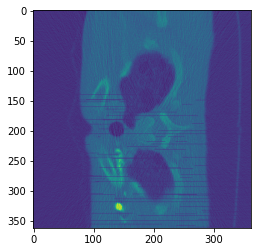

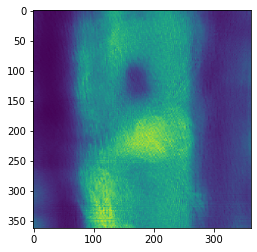

In [38]:
test = validation_dataset[20][0].to('cuda:0').unsqueeze(0)
test = test.unsqueeze(0)

fbp_test = fbp_batch(test)
test_out = loaded_model(fbp_test)
test_out = test_out.squeeze(0)
#test_out.shape
test_out = test_out.squeeze(0)
#test_out.shape
fbp_reconstruction = fbp(to_np(validation_dataset[20][0]))
plt.imshow(fbp_reconstruction)

show_img(test_out)
#test_output = model ()

In [ ]:
# Checking the change in size of input when passing throught the network

